<a href="https://colab.research.google.com/github/JuliMillan/IA_analisis/blob/main/IA_CDR_Col_Machos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import csv
import os
from numpy import median
from scipy.stats import iqr
from scipy.stats import kruskal
!pip install scikit-posthocs
import scikit_posthocs as sp

     |████████████████████████████████| 51kB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-cp37-none-any.whl size=37886 sha256=8046c8d6404be3d25fab45accd2f1975ee496213179dc253cb5bf6077b532a71
  Stored in directory: /root/.cache/pip/wheels/00/0f/56/897c22820a48a74f50f1a85faaa4b133bb8865e8b094b596f5
Successfully built scikit-posthocs


In [ ]:
#archivo = input("Ingrese el nombre del archivo")

In [ ]:
df = pd.read_csv('/content/IA_CDR_Colina_Machos.csv', sep=';')
df.head()

,Veh,0.3,0.8,1.3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,152.0,344.0,121.0,600.0,NaN,NaN,NaN,NaN,NaN
1,600.0,209.0,498.0,600.0,NaN,NaN,NaN,NaN,NaN
2,280.0,223.0,600.0,309.0,NaN,NaN,NaN,NaN,NaN
3,191.0,138.0,600.0,198.0,NaN,NaN,NaN,NaN,NaN
4,118.0,239.0,600.0,600.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Elimia las columnas y filas que tengan todos sus elementos vacios
df.dropna(axis='columns', how="all", inplace=True)
df.dropna(axis='index', how="all", inplace=True)
df

,Veh,0.3,0.8,1.3
0,152.0,344.0,121.0,600.0
1,600.0,209.0,498.0,600.0
2,280.0,223.0,600.0,309.0
3,191.0,138.0,600.0,198.0
4,118.0,239.0,600.0,600.0
5,308.0,NaN,600.0,NaN
7,31.0,182.0,178.0,600.0
8,98.0,75.0,241.0,61.0
9,160.0,600.0,230.0,210.0
10,210.0,154.0,28.0,312.0


### Visualización de los datos

In [ ]:
# reshape del dataframe para poder usar statsmodels
# Pone todos los tratamientos uno arriba del otro y al lado su latencia
# Queda una trabla tipo Tratamiento / Latencia
df_melt = pd.melt(df.reset_index(), value_vars=['Veh', '0.3', '0.8', '1.3'])
# reemplaza los nombres de las columnas
df_melt.columns = ['Tratamiento', 'Latencia']

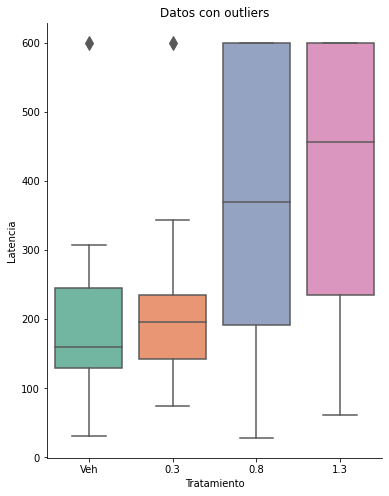

In [ ]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x='Tratamiento', y='Latencia', data=df_melt, palette="Set2", fliersize=10).set_title('Datos con outliers')
sns.despine()

In [ ]:
# generate a boxplot to see the data distribution by treatments
#ax = sns.boxplot(x='Tratamiento', y='Latencia', data=df_melt, palette="Set2", fliersize=10)
#ax = sns.swarmplot(x="Tratamiento", y="Latencia", data=df_melt, color=".25")
#sns.despine()
#sns.set_theme(font_scale=1.5)

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Veh    116.00
0.3     93.00
0.8    409.00
1.3    365.25
dtype: float64


In [ ]:
df_clean = df[(df > Q1 - 1.5 * IQR) & (df < Q3 + 1.5 * IQR)]
df_clean


,Veh,0.3,0.8,1.3
0,152.0,344.0,121.0,600.0
1,NaN,209.0,498.0,600.0
2,280.0,223.0,600.0,309.0
3,191.0,138.0,600.0,198.0
4,118.0,239.0,600.0,600.0
5,308.0,NaN,600.0,NaN
7,31.0,182.0,178.0,600.0
8,98.0,75.0,241.0,61.0
9,160.0,NaN,230.0,210.0
10,210.0,154.0,28.0,312.0


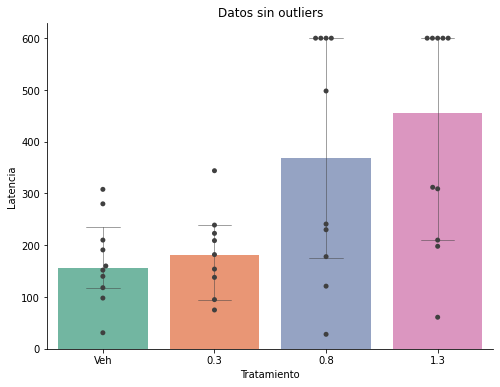

In [ ]:
# reshape del dataframe para poder usar statsmodels
df_melt_clean = pd.melt(df_clean.reset_index(), value_vars=['Veh', '0.3', '0.8', '1.3'])
# reemplaza los nombres de las columnas
df_melt_clean.columns = ['Tratamiento', 'Latencia']

plt.figure(figsize=(8,6))
ax = sns.barplot(x="Tratamiento", y="Latencia", data=df_melt_clean, estimator=median, palette="Set2", capsize=.3, errwidth=.5).set_title('Datos sin outliers')
ax = sns.swarmplot(x="Tratamiento", y="Latencia", data=df_melt_clean, color=".25")
sns.despine()


### Kruskal-Wallis

In [ ]:
#Con scypi
stat, p = kruskal(df_clean['Veh'], df_clean['0.3'], df_clean['0.8'], df_clean['1.3'], nan_policy='omit')
print('Statistics=%.3f, p=%.5f' % (stat, p))

alpha=0.05

if p > alpha:
    print('No hay diferencias significativas')
else:
    print('HAY diferencias significativas')

Statistics=9.861, p=0.01978
HAY diferencias significativas


#### Dunn's pos hoc multiple comparisons

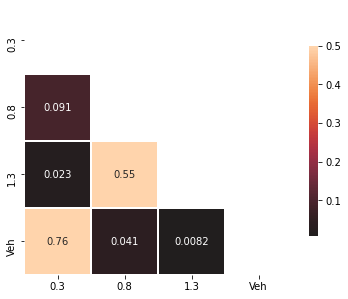

In [ ]:
## Acá estoy haciendo todos contra todos

dunn = sp.posthoc_dunn(df_melt_clean.dropna(), 'Latencia', 'Tratamiento')
#print(dunn)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dunn, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dunn, mask=mask, annot=True, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#dunn = sp.posthoc_dunn(df_clean.dropna(), df_clean[1:], df_clean['Veh'])
#print(dunn)

